In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

1. Исходные данные

In [2]:
# Фиксация генератора случайных чисел
random_seed = 1901
np.random.seed(random_seed)

# Значения предикторов для прогноза целевой переменной
# A_complex_max = [1800 + 1000j, 1500 + 1000j, 1800 + 1400j, 2000 + 1700j, 1500 + 1200j]
A_complex_max = [600 + 200j, 240 + 170j, 700 + 320j, 800 + 300j, 400 + 150j]

# Относительный размер тестовой выборки
test_size = 0.3

2. Загрузка датасетов

In [3]:
# Загрузка точных коэффициентов регрессии (для контроля обучения моделей)
z_complex_acc = pd.read_excel('C:\Datasets/dataset_z_complex_acc.xlsx').astype(complex)
z_complex_acc.T

,0,1,2,3,4
0,0.04+0.02j,0.035+0.015j,0.03+0.02j,0.020+0.012j,0.016+0.010j


In [4]:
# Загрузка датасета с данными из комплексных чисел
df_complex = pd.read_excel('C:\Datasets/dataset_complex_2.xlsx').astype(complex)
df_complex

,A_h_1,A_h_2,A_h_3,A_h_4,A_h_5,b_d
0,400.005510+150.002066j,199.983094+99.991547j,450.009763+200.004339j,600.047700+250.019875j,200.001796+100.000898j,39.200583+51.300763j
1,402.938265+151.101849j,202.688356+101.344178j,454.384083+201.948481j,608.095781+253.373242j,202.172245+101.086122j,39.609082+51.842365j
2,407.962003+152.985751j,205.221697+102.610848j,460.031711+204.458538j,616.833743+257.014060j,203.271658+101.635829j,40.099123+52.479623j
3,410.969392+154.113522j,206.256335+103.128168j,464.319915+206.364407j,625.855804+260.773252j,203.589493+101.794747j,40.461510+52.959228j
4,415.540179+155.827567j,207.158071+103.579035j,466.439858+207.306604j,632.881856+263.700773j,203.629064+101.814532j,40.784552+53.361314j
...,...,...,...,...,...,...
95,813.541376+305.078016j,416.768048+208.384024j,922.382835+409.947926j,1184.038236+493.349265j,434.087584+217.043792j,79.910514+104.655848j
96,819.693973+307.385240j,417.759601+208.879801j,929.971135+413.320505j,1185.080138+493.783391j,439.793498+219.896749j,80.369566+105.271201j
97,820.985581+307.869593j,421.845996+210.922998j,937.403074+416.623588j,1191.294097+496.372541j,444.896390+222.448195j,80.826875+105.910570j
98,828.149318+310.555994j,426.798587+213.399293j,947.137400+420.949956j,1204.144831+501.727013j,446.897548+223.448774j,81.619901+106.949367j


3. Попарные графики рассеяния модулей значений переменных датасета

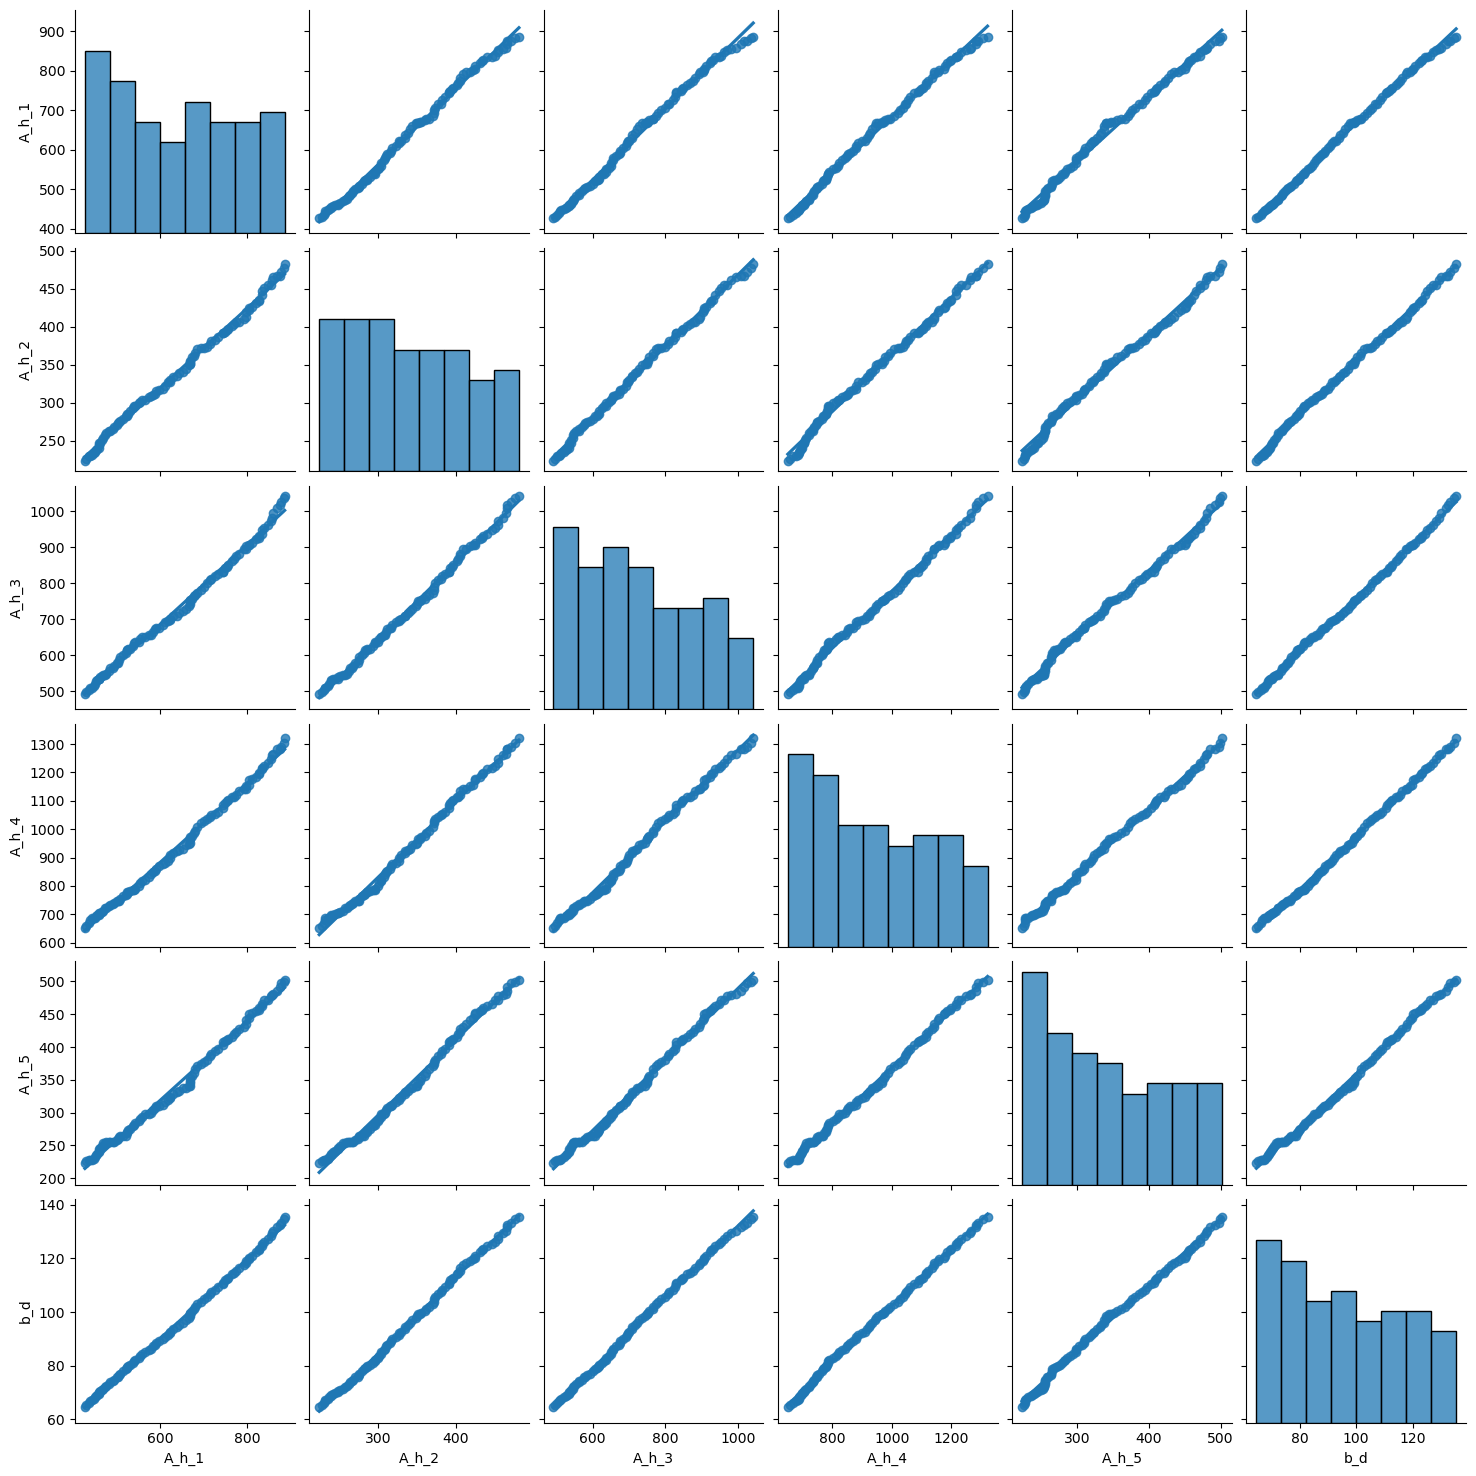

In [5]:
df_modul = df_complex.applymap(lambda x: abs(x))
sns.pairplot(df_modul, kind="reg")
plt.show()

4. Выделение комплексной матрицы признаков и комплексного вектора целевой переменной из датасета df_complex

In [6]:
A_complex = df_complex.iloc[:, :-1].values
b_complex = df_complex.iloc[:, -1].values
cond_A_complex = np.linalg.cond(A_complex.T @ A_complex)
det_A_complex = np.linalg.det(A_complex.T @ A_complex)

print(f'Число обусловленности матрицы A_complex: cond(A_complex) = {cond_A_complex.round(1)}')
print("Определитель матрицы A_complex:", det_A_complex)

Число обусловленности матрицы A_complex: cond(A_complex) = 235065.1
Определитель матрицы A_complex: (-6.151358471088519e+22-1.0888891549400429e+23j)


5. Разбиение на обучающую и тестовые выборки

In [7]:
A_train_complex, A_test_complex, b_train_complex, b_test_complex = train_test_split(A_complex, 
                                                                                    b_complex,
                                                                                    test_size=test_size,
                                                                                    random_state=random_seed)

6. Формирование вещественной матрицы A_train признаков и вещественного вектора b_train целевой переменной

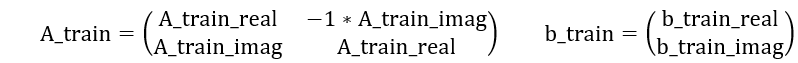


In [8]:
A_train_real = A_train_complex.real
A_train_imag = A_train_complex.imag
A_train_1 = pd.concat([pd.DataFrame(A_train_real), pd.DataFrame(A_train_imag)], axis=0)
A_train_2 = pd.concat([-1 * pd.DataFrame(A_train_imag), pd.DataFrame(A_train_real)], axis=0)
index_train = np.arange(A_train_1.shape[0])
A_train_1.index = index_train
A_train_2.index = index_train 
A_train = pd.merge(A_train_1, A_train_2, left_index=True, right_index=True)
A_train.columns = [f'A_{i+1}' for i in range(A_train.shape[1])]

In [9]:
b_train_real = b_train_complex.real
b_train_imag = b_train_complex.imag
b_train = pd.concat([pd.DataFrame(b_train_real), pd.DataFrame(b_train_imag)], axis=0)
b_train.index = index_train
b_train.columns = ['b']

7. Формирование вещественной матрицы A_test признаков и вещественного вектора b_test целевой переменной

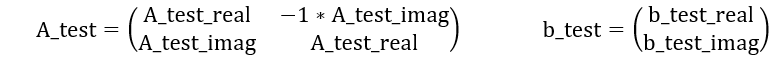

In [10]:
A_test_real = A_test_complex.real
A_test_imag = A_test_complex.imag
A_test_1 = pd.concat([pd.DataFrame(A_test_real), pd.DataFrame(A_test_imag)], axis=0)
A_test_2 = pd.concat([-1 * pd.DataFrame(A_test_imag), pd.DataFrame(A_test_real)], axis=0)
index_test = np.arange(A_test_1.shape[0])
A_test_1.index = index_test
A_test_2.index = index_test 
A_test = pd.merge(A_test_1, A_test_2, left_index=True, right_index=True)
A_test.columns = [f'A_{i+1}' for i in range(A_test.shape[1])]

In [11]:
b_test_real = b_test_complex.real
b_test_imag = b_test_complex.imag
b_test = pd.concat([pd.DataFrame(b_test_real), pd.DataFrame(b_test_imag)], axis=0)
b_test.index = index_test
b_test.columns = ['b']

8. Формирование вещественного вектора A_max для прогноза целевой переменной

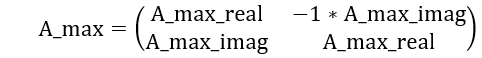

In [12]:
A_max_real = np.array(A_complex_max).real
A_max_imag = np.array(A_complex_max).imag
A_max_1 = pd.concat([pd.DataFrame(A_max_real), -1 * pd.DataFrame(A_max_imag)], axis=0)
A_max_2 = pd.concat([pd.DataFrame(A_max_imag), pd.DataFrame(A_max_real)], axis=0)
index_max = np.arange(A_max_1.shape[0])
A_max_1.index = index_max
A_max_2.index = index_max 
A_max = pd.merge(A_max_1, A_max_2, left_index=True, right_index=True)
A_max = A_max.T
A_max

,0,1,2,3,4,5,6,7,8,9
0_x,600.0,240.0,700.0,800.0,400.0,-200.0,-170.0,-320.0,-300.0,-150.0
0_y,200.0,170.0,320.0,300.0,150.0,600.0,240.0,700.0,800.0,400.0


9. Масштабирование признаков и вектора A_max

In [13]:
sc = MaxAbsScaler()    # MaxAbsScaler()    StandardScaler()

# Переход к привычным обозначениям X и y для признаков и целевых переменных
X_train_std = sc.fit_transform(A_train) 
X_test_std = sc.transform(A_test)
# X_train_std = A_train 
# X_test_std = A_test

y_train = b_train
y_test = b_test

In [14]:
A_max_std = sc.transform(A_max)
# A_max_std = A_max
pd.DataFrame(A_max_std).round(3)

,0,1,2,3,4,5,6,7,8,9
0,0.723,0.557,0.735,0.656,0.892,-0.241,-0.394,-0.336,-0.246,-0.334
1,0.241,0.394,0.336,0.246,0.334,0.723,0.557,0.735,0.656,0.892


10. Обучение моделей регрессоров на train-данных

In [15]:
metrics = {}

10.1 LinearRegression

In [16]:
lr = LinearRegression()
model_lr = lr.fit(X_train_std, y_train)

y_lr_pred = model_lr.predict(X_test_std)
y_lr_pred_train = model_lr.predict(X_train_std)

rmse_lr_train = np.sqrt(mean_squared_error(y_train, y_lr_pred_train)).round(3)
rmse_lr_test = np.sqrt(mean_squared_error(y_test, y_lr_pred)).round(3)
mae_lr_train = mean_absolute_error(y_train, y_lr_pred_train).round(3)
mae_lr_test = mean_absolute_error(y_test, y_lr_pred).round(3)
r2_lr_train = r2_score(y_train, y_lr_pred_train).round(3)
r2_lr_test = r2_score(y_test, y_lr_pred).round(3)
b_max_lr = model_lr.predict(A_max_std)[:].flatten().round(3)
b_max_lr_complex = complex(b_max_lr[0], b_max_lr[1])
b_max_lr_modul = np.sqrt(b_max_lr[0]**2 + b_max_lr[1]**2).round(3)
metrics['LinRegr'] = (str(r2_lr_train), str(r2_lr_test), b_max_lr_complex, str(b_max_lr_modul))

print(f'RMSE train: {rmse_lr_train}')
print(f'RMSE test:  {rmse_lr_test}')
print()
print(f'MAE train:  {mae_lr_train}')
print(f'MAE test:   {mae_lr_test}')
print()
print(f'R2 train:   {r2_lr_train}')
print(f'R2 test:    {r2_lr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_lr_complex}')
print(f'b max_modul:   {b_max_lr_modul}')
print()
print('Коэффициенты регрессии:')
print(pd.DataFrame(model_lr.coef_.flatten(), columns=['k']).round(3))
print(f'Свободный член регрессии  a0 =  {model_lr.intercept_.round(3)}')

RMSE train: 0.004
RMSE test:  0.004

MAE train:  0.004
MAE test:   0.004

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (57.782+75.165j)
b max_modul:   94.808

Коэффициенты регрессии:
        k
0  33.222
1  15.095
2  28.526
3  24.240
4   7.320
5  16.614
6   6.466
7  19.032
8  14.575
9   4.530
Свободный член регрессии  a0 =  [0.018]


10.2 Ridge

In [17]:
rid = Ridge()
rid_parameters = {'alpha': np.logspace(-7, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_rid = GridSearchCV(estimator=rid,
                   param_grid=rid_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_rid.fit(X_train_std, y_train)

y_rid_pred = model_rid.predict(X_test_std)
y_rid_pred_train = model_rid.predict(X_train_std)

rmse_rid_train = np.sqrt(mean_squared_error(y_train, y_rid_pred_train)).round(3)
rmse_rid_test = np.sqrt(mean_squared_error(y_test, y_rid_pred)).round(3)
mae_rid_train = mean_absolute_error(y_train, y_rid_pred_train).round(3)
mae_rid_test = mean_absolute_error(y_test, y_rid_pred).round(3)
r2_rid_train = r2_score(y_train, y_rid_pred_train).round(3)
r2_rid_test = r2_score(y_test, y_rid_pred).round(3)
b_max_rid = model_rid.predict(A_max_std)[:].flatten().round(3)
b_max_rid_complex = complex(b_max_rid[0], b_max_rid[1])
b_max_rid_modul = np.sqrt(b_max_rid[0]**2 + b_max_rid[1]**2).round(3)
metrics['Ridge'] = (str(r2_rid_train), str(r2_rid_test), b_max_rid_complex, str(b_max_rid_modul))

print(f'RMSE train: {rmse_rid_train}')
print(f'RMSE test:  {rmse_rid_test}')
print()
print(f'MAE train:  {mae_rid_train}')
print(f'MAE test:   {mae_rid_test}')
print()
print(f'R2 train:   {r2_rid_train}')
print(f'R2 test:    {r2_rid_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_rid_complex}')
print(f'b max_modul:   {b_max_rid_modul}')
model_rid.best_params_

RMSE train: 0.004
RMSE test:  0.005

MAE train:  0.004
MAE test:   0.004

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (57.784+75.166j)
b max_modul:   94.81


{'alpha': 3.981071705534969e-06, 'random_state': 1}

10.3 Lasso

In [18]:
las = Lasso()
las_parameters = {'alpha': np.logspace(-5, 3, num=101), 
                  'random_state':[1, 7, 42, 100]
}
model_las = GridSearchCV(estimator=las,
                   param_grid=las_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_las.fit(X_train_std, y_train)

y_las_pred = model_las.predict(X_test_std)
y_las_pred_train = model_las.predict(X_train_std)

rmse_las_train = np.sqrt(mean_squared_error(y_train, y_las_pred_train)).round(3)
rmse_las_test = np.sqrt(mean_squared_error(y_test, y_las_pred)).round(3)
mae_las_train = mean_absolute_error(y_train, y_las_pred_train).round(3)
mae_las_test = mean_absolute_error(y_test, y_las_pred).round(3)
r2_las_train = r2_score(y_train, y_las_pred_train).round(3)
r2_las_test = r2_score(y_test, y_las_pred).round(3)
b_max_las = model_las.predict(A_max_std)[:].flatten().round(3)
b_max_las_complex = complex(b_max_las[0], b_max_las[1])
b_max_las_modul = np.sqrt(b_max_las[0]**2 + b_max_las[1]**2).round(3)
metrics['Lasso'] = (str(r2_las_train), str(r2_las_test), b_max_las_complex, str(b_max_las_modul))

print(f'RMSE train: {rmse_las_train}')
print(f'RMSE test:  {rmse_las_test}')
print()
print(f'MAE train:  {mae_las_train}')
print(f'MAE test:   {mae_las_test}')
print()
print(f'R2 train:   {r2_las_train}')
print(f'R2 test:    {r2_las_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_las_complex}')
print(f'b max_modul:   {b_max_las_modul}')
model_las.best_params_

RMSE train: 0.293
RMSE test:  0.304

MAE train:  0.202
MAE test:   0.216

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (59.187+76.249j)
b max_modul:   96.525


{'alpha': 0.003019951720402016, 'random_state': 1}

10.4 ElasticNet

In [19]:
en = ElasticNet()
en_parameters = {'alpha': np.logspace(-5, 3, num=101),
                 'l1_ratio': (0.05, 0.1, 0.3, 0.5, 0.7, 0.9),
                 'random_state':[1, 7, 42, 100]
}
model_en = GridSearchCV(estimator=en,
                   param_grid=en_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_en.fit(X_train_std, y_train)

y_en_pred = model_en.predict(X_test_std)
y_en_pred_train = model_en.predict(X_train_std)

rmse_en_train = np.sqrt(mean_squared_error(y_train, y_en_pred_train)).round(3)
rmse_en_test = np.sqrt(mean_squared_error(y_test, y_en_pred)).round(3)
mae_en_train = mean_absolute_error(y_train, y_en_pred_train).round(3)
mae_en_test = mean_absolute_error(y_test, y_en_pred).round(3)
r2_en_train = r2_score(y_train, y_en_pred_train).round(3)
r2_en_test = r2_score(y_test, y_en_pred).round(3)
b_max_en = model_en.predict(A_max_std).round(3)
b_max_en_complex = complex(b_max_en[0], b_max_en[1])
b_max_en_modul = np.sqrt(b_max_en[0]**2 + b_max_en[1]**2).round(3)
metrics['ElastNet'] = (str(r2_en_train), str(r2_en_test), b_max_en_complex, str(b_max_en_modul))

print(f'RMSE train: {rmse_en_train}')
print(f'RMSE test:  {rmse_en_test}')
print()
print(f'MAE train:  {mae_en_train}')
print(f'MAE test:   {mae_en_test}')
print()
print(f'R2 train:   {r2_en_train}')
print(f'R2 test:    {r2_en_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_en_complex}')
print(f'b max_modul:   {b_max_en_modul}')
model_en.best_params_

RMSE train: 0.159
RMSE test:  0.191

MAE train:  0.128
MAE test:   0.153

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (58.957+74.417j)
b max_modul:   94.941


{'alpha': 0.00047863009232263805, 'l1_ratio': 0.1, 'random_state': 1}

10.5 TheilSenRegressor

In [20]:
tsr = TheilSenRegressor()
tsr_parameters = {'random_state':[1, 7, 42, 100]
}
model_tsr = GridSearchCV(estimator=tsr,
                   param_grid=tsr_parameters,
                   scoring='r2', # 'neg_mean_absolute_error'
                   n_jobs=-1,
                   cv=5)
model_tsr.fit(X_train_std, y_train)

y_tsr_pred = model_tsr.predict(X_test_std)
y_tsr_pred_train = model_tsr.predict(X_train_std)

rmse_tsr_train = np.sqrt(mean_squared_error(y_train, y_tsr_pred_train)).round(3)
rmse_tsr_test = np.sqrt(mean_squared_error(y_test, y_tsr_pred)).round(3)
mae_tsr_train = mean_absolute_error(y_train, y_tsr_pred_train).round(3)
mae_tsr_test = mean_absolute_error(y_test, y_tsr_pred).round(3)
r2_tsr_train = r2_score(y_train, y_tsr_pred_train).round(3)
r2_tsr_test = r2_score(y_test, y_tsr_pred).round(3)
b_max_tsr = model_tsr.predict(A_max_std).round(3)
b_max_tsr_complex = complex(b_max_tsr[0], b_max_tsr[1])
b_max_tsr_modul = np.sqrt(b_max_tsr[0]**2 + b_max_tsr[1]**2).round(3)
metrics['TheilSen'] = (str(r2_tsr_train), str(r2_tsr_test), b_max_tsr_complex, str(b_max_tsr_modul))

print(f'RMSE train: {rmse_tsr_train}')
print(f'RMSE test:  {rmse_tsr_test}')
print()
print(f'MAE train:  {mae_tsr_train}')
print(f'MAE test:   {mae_tsr_test}')
print()
print(f'R2 train:   {r2_tsr_train}')
print(f'R2 test:    {r2_tsr_test}')
print()
print(f'Прогноз целевой переменной:')
print(f'b max_complex: {b_max_tsr_complex}')
print(f'b max_modul:   {b_max_tsr_modul}')
model_tsr.best_params_

RMSE train: 0.01
RMSE test:  0.012

MAE train:  0.008
MAE test:   0.01

R2 train:   1.0
R2 test:    1.0

Прогноз целевой переменной:
b max_complex: (57.716+75.138j)
b max_modul:   94.746


{'random_state': 1}

11. Средние значения метрик регрессоров и целевой переменной b

In [21]:
r2_train_values = [metrics[key][-4] for key in metrics]
r2_train_values = [float(value) for value in r2_train_values[:-1]]
r2_train_mean = round(sum(r2_train_values) / len(r2_train_values), 3)
r2_test_values = [metrics[key][-3] for key in metrics]
r2_test_values = [float(value) for value in r2_test_values[:-1]]
r2_test_mean = round(sum(r2_test_values) / len(r2_test_values), 3)
b_max_values = [metrics[key][-2] for key in metrics]
b_max_mean = sum(b_max_values) / len(b_max_values)
b_max_real_round = round(b_max_mean.real, 3)
b_max_imag_round = round(b_max_mean.imag, 3)
b_max_mean_complex = complex(b_max_real_round, b_max_imag_round)
b_max_mean_modul = np.sqrt(b_max_real_round**2 + b_max_imag_round**2).round(3)
metrics['Mean'] = (str(r2_train_mean), str(r2_test_mean), b_max_mean_complex, str(b_max_mean_modul))

print(f'Средние значения прогноза целевой переменной различными регрессорами:')
print(f'b_max_mean_complex: {b_max_mean_complex}')
print(f'b_max_mean_modul: {b_max_mean_modul}')

Средние значения прогноза целевой переменной различными регрессорами:
b_max_mean_complex: (58.285+75.227j)
b_max_mean_modul: 95.164


12. Точный прогноз целевой переменной b

In [22]:
b_max_acc_complex = np.dot(np.array(A_complex_max), np.array(z_complex_acc)).round(3)
b_max_acc_modul = abs(b_max_acc_complex).round(3)
metrics['Accurate'] = ('', '', b_max_acc_complex[0], b_max_acc_modul[0])

print(f'Точный прогноз целевой переменной по известным точным коэффициентам регрессии:')
print(f'b_max_acc_complex: {b_max_acc_complex[0]}')
print(f'b_max_acc_modul: {b_max_acc_modul[0]}')

Точный прогноз целевой переменной по известным точным коэффициентам регрессии:
b_max_acc_complex: (57.75+75.15j)
b_max_acc_modul: 94.777


13. Сводная таблица метрик и прогнозов моделей

In [23]:
df_metrics = pd.DataFrame(metrics)
df_metrics.index = ['R2 train', 'R2 test', 'b_max_complex', 'b_max_modul']
df_metrics = df_metrics.astype(object)
df_metrics

,LinRegr,Ridge,Lasso,ElastNet,TheilSen,Mean,Accurate
R2 train,1.0,1.0,1.0,1.0,1.0,1.0,
R2 test,1.0,1.0,1.0,1.0,1.0,1.0,
b_max_complex,(57.782+75.165j),(57.784+75.166j),(59.187+76.249j),(58.957+74.417j),(57.716+75.138j),(58.285+75.227j),(57.75+75.15j)
b_max_modul,94.808,94.81,96.525,94.941,94.746,95.164,94.777
